# Different implementation for feature extraction and reverse image search

This notebook shows various ways of scoring and evaluating the results of reverse image search.

### Source: https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. You may have already downloaded this dataset from the previous notebook, `7a_transfer_learning.ipynb`. If not, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

In [1]:
#%tensorflow_version 1.x

In [2]:
# Let's look at the processor we're running
!nvidia-smi

Sat Feb 19 12:33:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8     8W /  N/A |    707MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

We will load a previously-trained neural network, that of ResNet, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

In [57]:
model = ResNet50(weights='imagenet', include_top=True,
                 input_shape=(224, 224, 3))

def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img).transpose()
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    
    return normalized_features

Let's look at the model summary to see how it's structured.  Note the last layer is the predictions layer which we will remove in order to get our features.

In [18]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [53]:
# We remove the dense predictions layer to get our featuers of length 2048
from keras.models import Model

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [54]:
# Using original model we get predictions layer, length 1000
features = extract_features('./gdrive/MyDrive/101_ObjectCategories/airplanes/image_0001.jpg', model)
print(len(features))

(1, 224, 224, 3)
(1000, 1)
<class 'numpy.ndarray'>
1000
1000


In [55]:
# Using new model we get activation layer, length 2048
features = extract_features('./gdrive/MyDrive/101_ObjectCategories/airplanes/image_0001.jpg', feat_extractor)
print(len(features))
print(np.amax(features))
print(np.amin(features))

(1, 224, 224, 3)
(2048, 1)
<class 'numpy.ndarray'>
2048
2048
0.25557414
0.0


In [23]:
!ls ./gdrive/MyDrive/101_ObjectCategories

accordion		   crocodile	    joshua_tree        revolver
airplanes		   crocodile_head   kangaroo	       rhino
all			   cup		    ketch	       rooster
anchor			   dalmatian	    lamp	       saxophone
ant			   dollar_bill	    laptop	       schooner
barrel			   dolphin	    Leopards	       scissors
bass			   dragonfly	    llama	       scorpion
beaver			   electric_guitar  lobster	       sea_horse
binocular		   elephant	    lotus	       snoopy
bonsai			   emu		    mandolin	       soccer_ball
brain			   euphonium	    mayfly	       stapler
brontosaurus		   ewer		    menorah	       starfish
buddha			   Faces	    metrics300_4000.p  stegosaurus
butterfly		   ferry	    metrics300.p       stop_sign
CalTechFeatures.p	   flamingo	    metrics.p	       strawberry
CalTechFeatures.p.justPca  flamingo_head    metronome	       sunflower
camera			   foo		    minaret	       tick
cannon			   garfield	    Motorbikes	       tmp
car_side		   gerenuk	    nautilus	       trilobite
ceiling_fan		   gramophone	    octo

In [56]:
images_path = './gdrive/MyDrive/101_ObjectCategories'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

filenames = [os.path.join(dp, f) for dp, dn, fn in os.walk(images_path) for f in fn if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 7442 images to analyze


In [58]:
# Loop through all images and extract the feature vector for each image.
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], feat_extractor))

/tmp/ipykernel_638660/1352785518.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/7442 [00:00<?, ?it/s]

In [59]:
# Save these out to file to save time on future runs
#pickle.dump(feature_list, open('./gdrive/MyDrive/101_ObjectCategories/features-caltech101-resnet.pickle', 'wb'))
#pickle.dump(filenames, open('./gdrive/MyDrive/101_ObjectCategories/filenames-caltech101.pickle','wb'))

In [9]:
import pickle

# Read in features
feature_list = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/features-caltech101-resnet.pickle', 'rb'))
filenames = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/filenames-caltech101.pickle', 'rb'))
print(len(feature_list))
print(feature_list[0].shape)

7442
(2048,)


In [82]:
# Let's use KNN to determine our 5 closest images
from sklearn.neighbors import NearestNeighbors

print(len(feature_list))
print(feature_list[0].shape)
print(feature_list[1].shape)

# Here use brute force euclicean metric (Q: same as cosine similarity?)
# TODO: compare different KNNs
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])
print('------------')
for i in range(5):
    print(distances[0][i])
    print(indices[0][i])
neighbors10 = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors10.kneighbors([feature_list[0]])
print('------------')
for i in range(10):
    print(distances[0][i])
    print(indices[0][i])


7442
(2048,)
(2048,)
------------
4.712161e-08
0
0.35610163
9
0.49782452
11
0.52564955
59
0.5547591
2706
------------
4.712161e-08
0
0.35610163
9
0.49782452
11
0.52564955
59
0.5547591
2706
0.57274854
33
0.58248687
40
0.58276093
49
0.60115916
2621
0.61520845
8


In [143]:
def get_closest_images(query_image_idx, num_results=5):
    # Get 1 additional since we skip first one which is presumably the input image
    neighbors = NearestNeighbors(n_neighbors=num_results+1, algorithm='brute', metric='euclidean').fit(feature_list)
    distances, indices = neighbors.kneighbors([feature_list[query_image_idx]])

    # Skip first one which is presumably the input image
    return indices[0][1:6]

In [123]:
# Build mapping of image to the category the image is in so we can do scoring.
class_string_ids = []
class_ids = []
classToIdx = {}
idxToClass = {}
idx = 1
for i in range(len(filenames)):
    paths = filenames[i].split('/')
    class_string_ids.append(paths[4])
    if paths[4] not in classToIdx:
        classToIdx[paths[4]] = idx
        idxToClass[idx] = paths[4]
        idx += 1

    class_ids.append(classToIdx[paths[4]])

print(len(class_string_ids))
print(len(class_ids))

7442
7442


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.206332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.847641
[t-SNE] KL divergence after 1000 iterations: 0.915291
(4000, 2)
<class 'numpy.ndarray'>


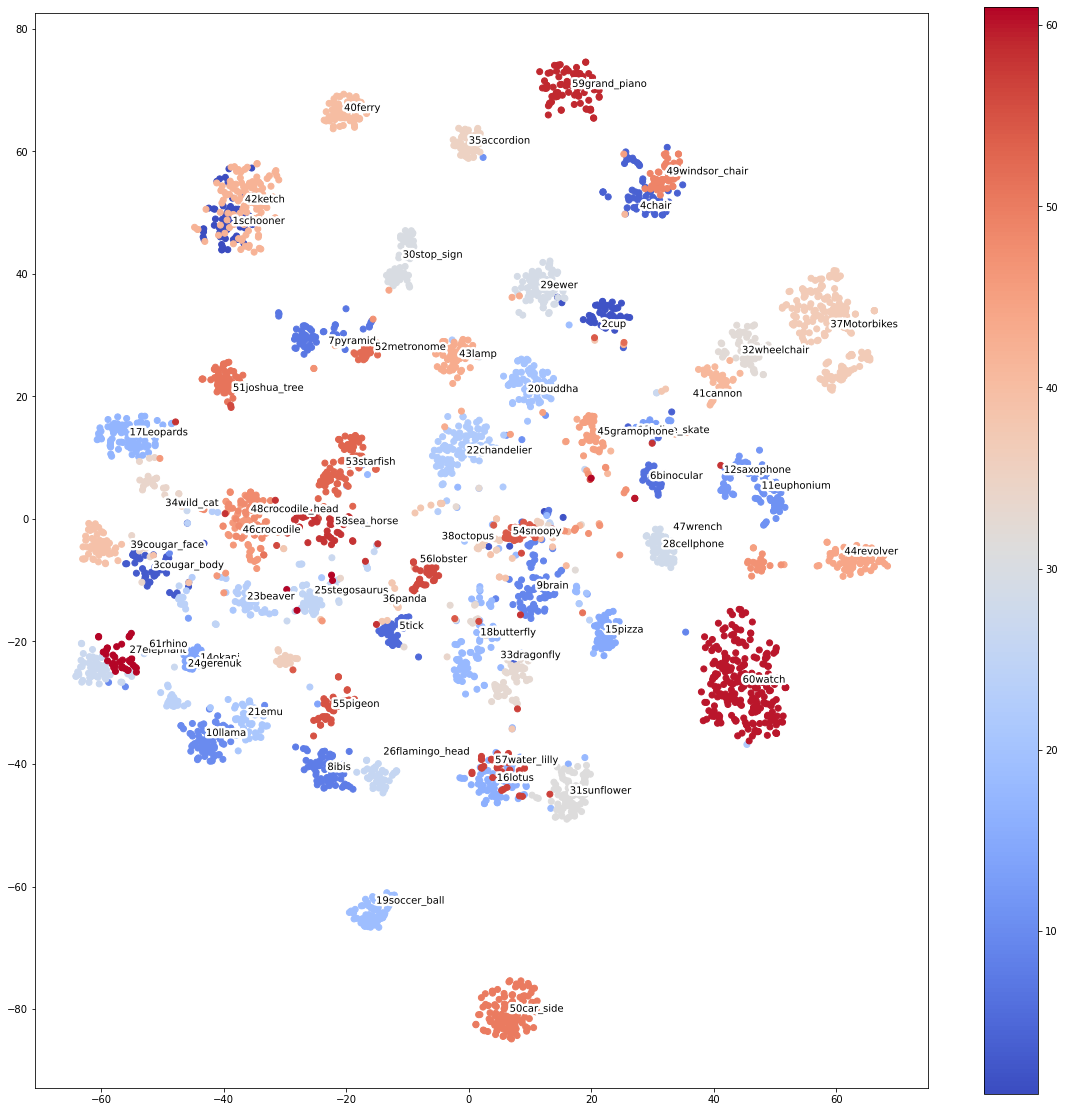

In [121]:
# Use t-SNE to visualize clusters in high dimensional space
# For a good talk on how TSNE works: https://www.youtube.com/watch?v=RJVL80Gg3lA

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from more_itertools import locate
import matplotlib.patheffects as PathEffects

# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

uids = np.unique(selected_class_ids)

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
print(tsne_results.shape)
print(type(tsne_results))

# Plot a scatter plot from the generated t-SNE results
plt.rcParams["figure.figsize"] = (20,20)
ax = plt.subplot(aspect='equal')

colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)

# We add the labels for each cluster?
txts = []
for id in uids:
    # Position of each label.
    idx = list(locate(selected_class_ids, lambda a: a == id))
    #xtext = np.median(tsne_results[idx,0])
    #ytext = np.median(tsne_results[idx,1])
    xtext = np.mean(tsne_results[idx,0])
    ytext = np.mean(tsne_results[idx,1])
    #xtext, ytext = np.median(tsne_results[idx,0],tsne_results[idx,1], axis=0)
    txt = ax.text(xtext, ytext, str(id)+idxToClass[id], fontsize=10)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


plt.show()

In [146]:
# To bridge impl
images = filenames
imageToCategory = {}
closestForImagePath = {}

# This takes ~5 min on a GPU, hours on CPU
for i in tqdm_notebook(range(len(filenames))):
    paths = filenames[i].split('/')
    imageToCategory[filenames[i]] = paths[4]
    closestForImagePath[filenames[i]] = get_closest_images(i)

/tmp/ipykernel_638660/1986669575.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/7442 [00:00<?, ?it/s]

In [147]:
# Save these out to file to save time on future runs
#pickle.dump([images,imageToCategory,closestForImagePath], open('./gdrive/MyDrive/101_ObjectCategories/features-caltech101-resnet-closest.pickle', 'wb'))

In [ ]:
# Read in features
[images,imageToCategory,closestForImagePath] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/features-caltech101-resnet-closest.pickle', 'rb'))

In [148]:
# Create confusion matrix
categories = sorted(set(imageToCategory.values()))
print('num categories=', str(len(categories)))
print('num images=', str(len(filenames)))

categoryToIdx = {}
idxToCategory = {}
for idx, category in enumerate(categories):
    categoryToIdx[category] = idx
    idxToCategory[idx] = category

#print(categoryToIdx)
#print(idxToCategory)

totalForCategory = {}
cm = np.zeros([len(categories), len(categories)], dtype=int)
count=0
for image_path in images:
    count += 1
    cat1 = imageToCategory[image_path]
    if cat1 not in totalForCategory:
        #print(str(count), ' ', cat1)
        totalForCategory[cat1] = 0
    totalForCategory[cat1] = totalForCategory[cat1] + 1        
    
    idx1 = categoryToIdx[cat1]
    closest = closestForImagePath[image_path]
    for i in closest:
        cat2 = imageToCategory[images[i]]
        idx2 = categoryToIdx[cat2]
        cm[idx1][idx2] += 1
        
i,j = np.unravel_index(cm.argmax(), cm.shape)
print('Max:', str(i), ' ', str(j), ' ', str(cm[i][j]), ' ', idxToCategory[i])
print(cm)
print(totalForCategory)
for i in range(len(categories)):
    cat = idxToCategory[i]
    print(i, ' ', cat, ' ', totalForCategory[cat])

num categories= 99
num images= 7442
Max: 4   4   3982   airplanes
[[2168    0    0 ...    0    0    0]
 [   0  485    0 ...    0    0    0]
 [   0    0  999 ...    0    0    0]
 ...
 [   0    0    0 ...  264    0    0]
 [   0    0    0 ...    0  113    0]
 [   0    0    0 ...    0    0  267]]
{'schooner': 63, 'cup': 57, 'cougar_body': 47, 'chair': 62, 'tick': 49, 'binocular': 33, 'pyramid': 57, 'ibis': 70, 'brain': 80, 'llama': 78, 'euphonium': 64, 'saxophone': 40, 'inline_skate': 31, 'okapi': 39, 'pizza': 53, 'lotus': 66, 'Leopards': 98, 'butterfly': 91, 'soccer_ball': 64, 'buddha': 85, 'emu': 53, 'chandelier': 107, 'beaver': 46, 'gerenuk': 34, 'stegosaurus': 59, 'flamingo_head': 45, 'elephant': 64, 'cellphone': 59, 'ewer': 85, 'stop_sign': 64, 'sunflower': 85, 'wheelchair': 59, 'dragonfly': 68, 'wild_cat': 34, 'accordion': 55, 'panda': 38, 'Motorbikes': 200, 'octopus': 35, 'cougar_face': 69, 'ferry': 67, 'cannon': 43, 'ketch': 114, 'lamp': 61, 'revolver': 82, 'gramophone': 51, 'croco

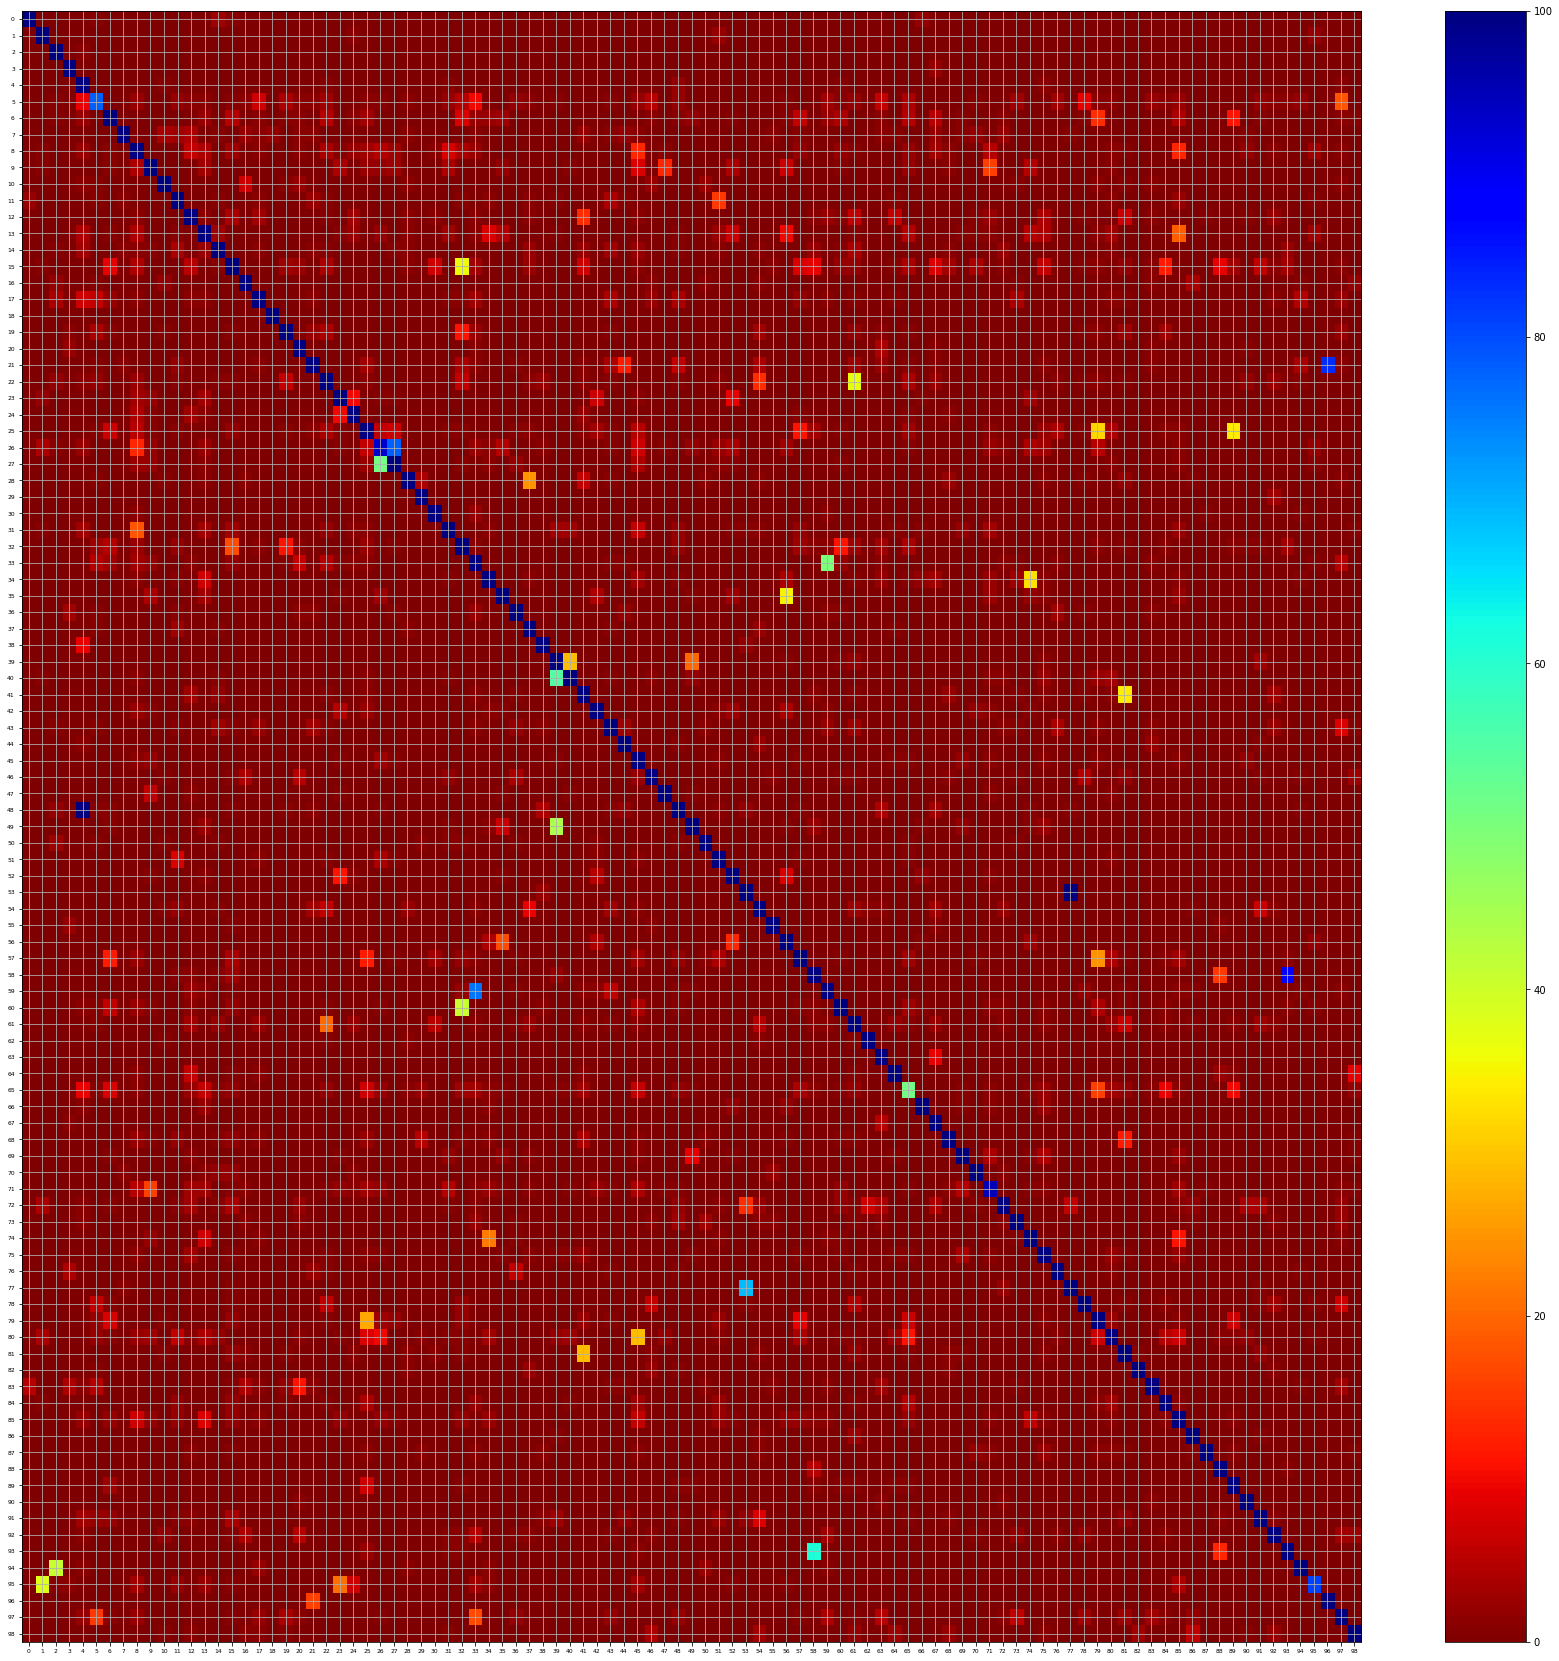

In [149]:
N = len(categories)

ticks=np.linspace(0, N-1, num=N)
plt.rcParams["figure.figsize"] = (30,30)

#clim = np.amax(cm)
#plt.imshow(cm, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=clim)
plt.imshow(cm, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=100)
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)

plt.show()

Max of all elements= 3982
Max of off-diagonal elements= 160


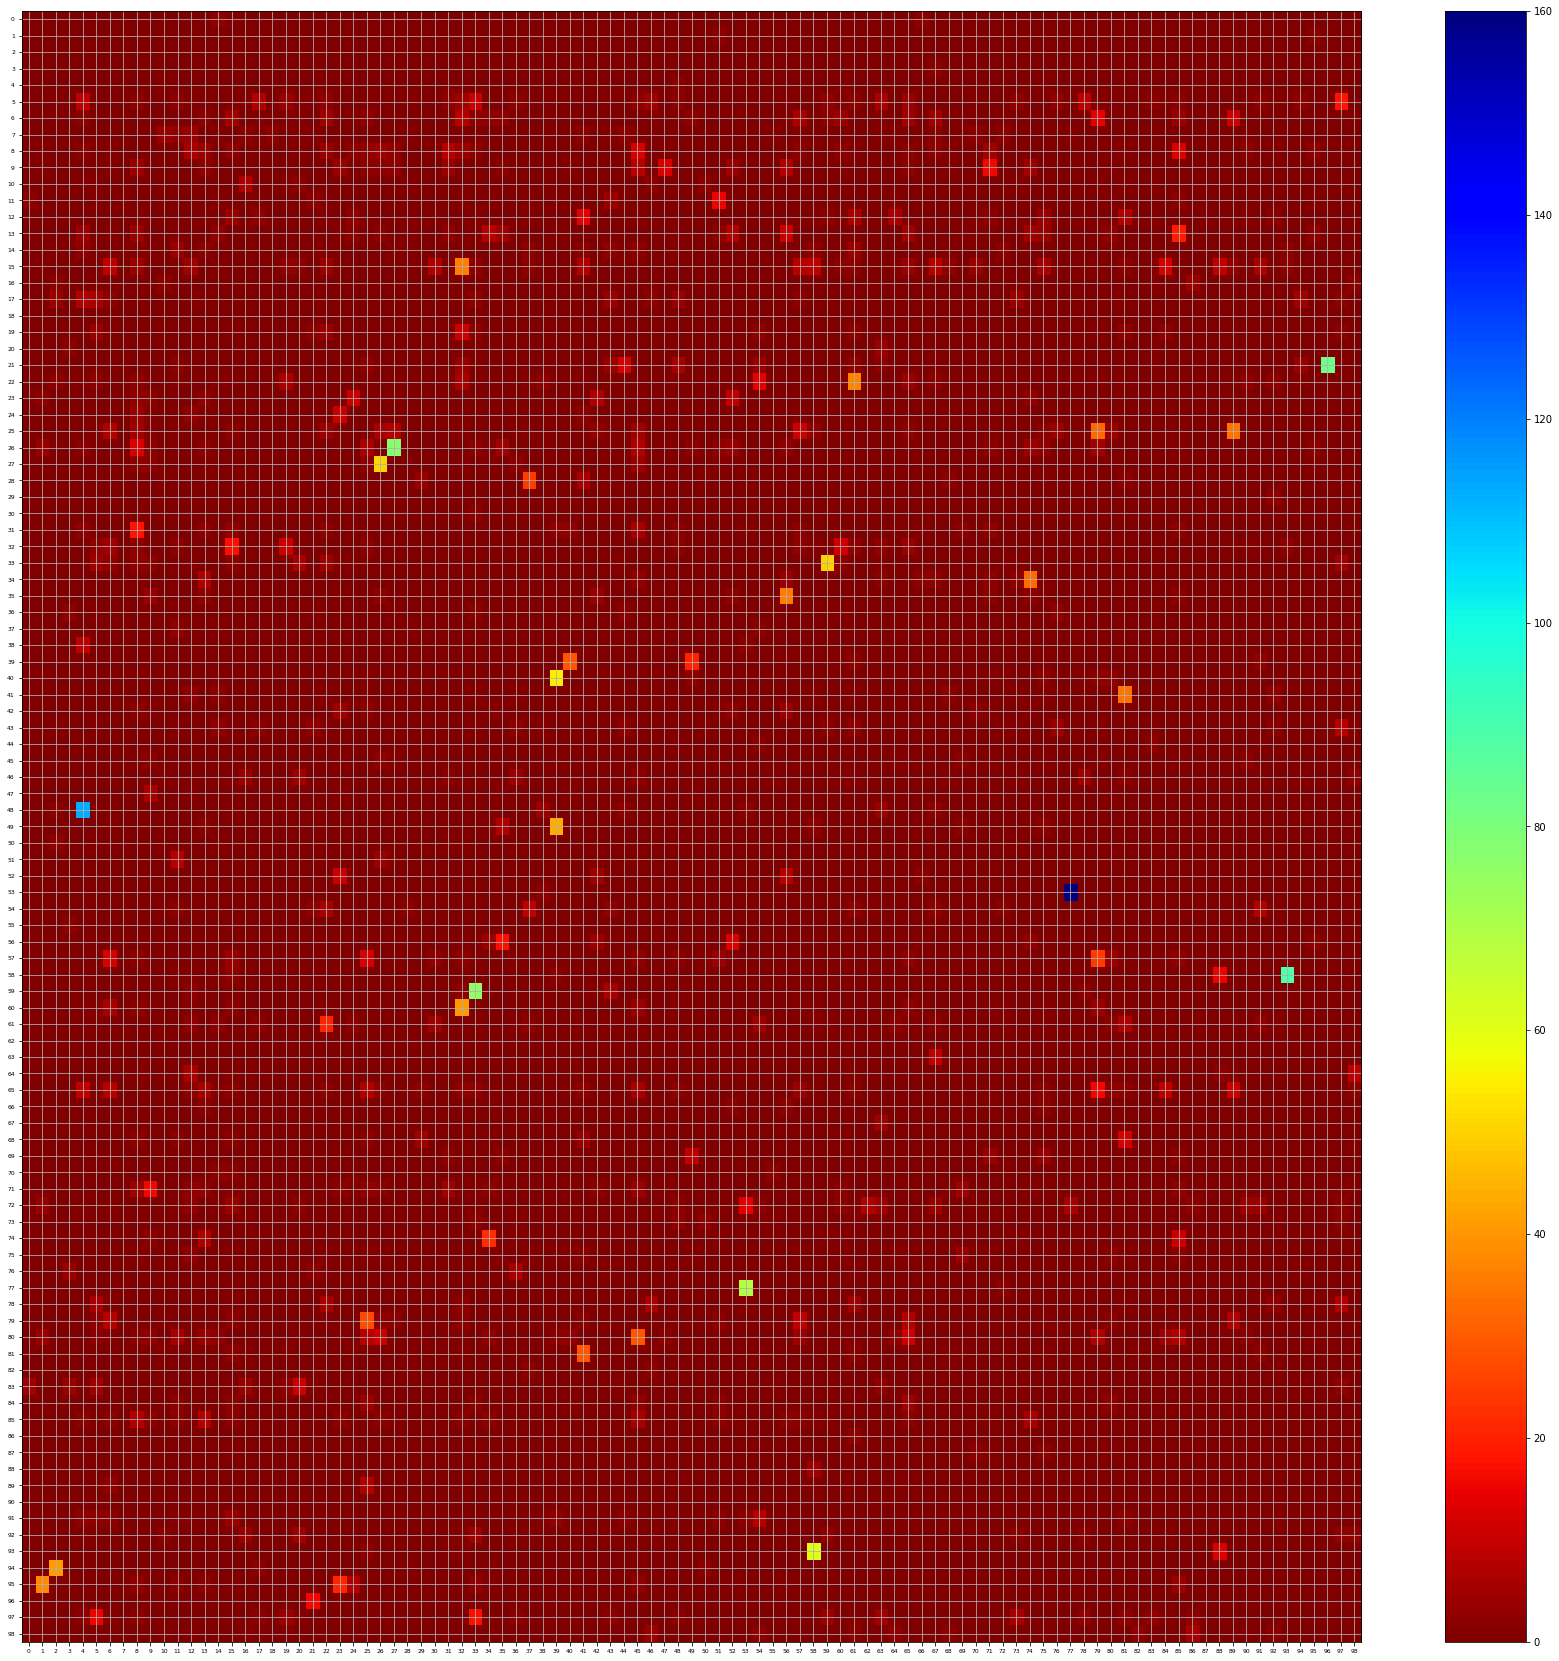

In [150]:
ticks=np.linspace(0, N-1, num=N)
plt.rcParams["figure.figsize"] = (30,30)

cm2 = np.copy(cm)
for i in range(N):
    cm2[i][i] = 0

clim2 = np.amax(cm2)
print('Max of all elements=', str(np.amax(cm)))
print('Max of off-diagonal elements=', str(clim2))

plt.imshow(cm2, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=clim2)
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)

plt.show()

In [151]:
# Look at categories with misclassification
N = len(categories)
threshold = 30
for i in range (N-1):
    for j in range(i+1, N):
        if cm[i][j] > threshold:
            print(str(i), ', ', str(j), ', ', str(cm[i][j]), ' (', categories[i], ', ', categories[j], ')')

15 ,  32 ,  36  ( butterfly ,  dragonfly )
21 ,  96 ,  83  ( chair ,  windsor_chair )
22 ,  61 ,  37  ( chandelier ,  menorah )
25 ,  79 ,  32  ( crab ,  scorpion )
25 ,  89 ,  34  ( crab ,  tick )
26 ,  27 ,  78  ( crocodile ,  crocodile_head )
33 ,  59 ,  50  ( electric_guitar ,  mandolin )
34 ,  74 ,  33  ( elephant ,  rhino )
35 ,  56 ,  35  ( emu ,  llama )
41 ,  81 ,  34  ( garfield ,  snoopy )
53 ,  77 ,  160  ( ketch ,  schooner )
58 ,  93 ,  89  ( lotus ,  water_lilly )
